# Import

In [1]:
import collections
import numpy as np
import matplotlib.patches as patches
import sys
import pickle
import pandas as pd
import copy
import functools
import json
import os
import itertools as it
import random
import inspect
import scipy.stats
import getpass
import os.path as osp
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
from matplotlib.ticker import MaxNLocator
import matplotlib.patches as mpatches
import seaborn as sns
from matplotlib import rcParams
from matplotlib import rc
 
from rliable import library as rly
from rliable import metrics
from rliable import plot_utils

In [4]:

RAND_STATE = np.random.RandomState(42)

sns.set_style("white")

# Matplotlib params
rcParams['legend.loc'] = 'best'
rcParams['pdf.fonttype'] = 42
rcParams['ps.fonttype'] = 42
rc('text', usetex=False)

# Stratified Bootstrap CIs and Aggregate metrics
StratifiedBootstrap = rly.StratifiedBootstrap

IQM = lambda x: metrics.aggregate_iqm(x) # Interquartile Mean
OG = lambda x: metrics.aggregate_optimality_gap(x, 1.0) # Optimality Gap
MEAN = lambda x: metrics.aggregate_mean(x)
MEDIAN = lambda x: metrics.aggregate_median(x)

RANDOM_SCORES = {
    'Breakout-ramDeterministic-v4': 1.7,
}
HUMAN_SCORES = {
    'Breakout-ramDeterministic-v4': 30.5,
}

In [5]:
def save_fig(fig, name):
  dir = '/Users/khuongle/Documents/4th-semester/cs492/spinningup_stable/spinningup/media'
  file_name = osp.join(dir, '{}.pdf'.format(name))
  fig.savefig(file_name, format='pdf', bbox_inches='tight')
  return file_name

In [6]:
def convert_to_matrix(score_dict):
   keys = sorted(list(score_dict.keys()))
   return np.stack([score_dict[k] for k in keys], axis=1)

def score_normalization(res_dict, min_score, max_score):
  norm_scores = {}
  for algo, scores in res_dict.items():
    norm_scores[algo] = (scores - min_score)/(max_score - min_score)
  return norm_scores

In [12]:
def load_data_by_algo(
    tasks, 
    data_files, 
    evaluation_key, 
    normalization=False, 
    minscores=RANDOM_SCORES, 
    maxscores=HUMAN_SCORES
):
    ret = []
    for task, filename in zip(tasks, data_files):
        df = pd.read_table(filename)
        if str('AverageTest' + evaluation_key) in df.keys():
            val = df['AverageTest' + evaluation_key].values.mean()
        elif str('Average' + evaluation_key) in df.keys():
            val = df['Average' + evaluation_key].values.mean()
        elif evaluation_key in df.keys():
            val = df[evaluation_key].values.mean()
                
        if normalization:
            val = (val - minscores[task]) / (maxscores[task] - minscores[task])
        
        ret.append(val)
    
    return ret   

In [8]:
def load_data(
        algos, 
        tasks,
        data_files, 
        evaluation_key = 'EpRet', 
        normalization = False
    ):
    # load datasets
    datadict = {}
    datasets = []
    for i in range(len(algos)):
        score = []
        for j in range(len(data_files[i])):
            score.append(load_data_by_algo(tasks, data_files[i][j], evaluation_key, normalization))
        datadict[algos[i]] = np.asarray(score)
        datasets.append(score)
    return datadict, np.asarray(datasets)

In [13]:
tasks = ['Breakout-ramDeterministic-v4']
algos = ['PPO', 'TRPO', 'DQN', 'SACD']
# data_files = (algos x runs x tasks)
# data_files[PPO, run0, Breakout]
algo1runxtask = [
    [
        '/Users/khuongle/Documents/4th-semester/cs492/spinningup_stable/spinningup/data/ppo_Breakout-ramDeterministic-v4/ppo_Breakout-ramDeterministic-v4_s928/model.txt',
    ],
    [
        '/Users/khuongle/Documents/4th-semester/cs492/spinningup_stable/spinningup/data/ppo_Breakout-ramDeterministic-v4/ppo_Breakout-ramDeterministic-v4_s485/model2483.txt',
    ],
    [
        '/Users/khuongle/Documents/4th-semester/cs492/spinningup_stable/spinningup/data/ppo_Breakout-ramDeterministic-v4/ppo_Breakout-ramDeterministic-v4_s485/model2493.txt',
    ],
    [
        '/Users/khuongle/Documents/4th-semester/cs492/spinningup_stable/spinningup/data/ppo_Breakout-ramDeterministic-v4/ppo_Breakout-ramDeterministic-v4_s485/model2497.txt',
    ],
    [
        '/Users/khuongle/Documents/4th-semester/cs492/spinningup_stable/spinningup/data/ppo_Breakout-ramDeterministic-v4/ppo_Breakout-ramDeterministic-v4_s555/model2499.txt',
    ],
    [
        '/Users/khuongle/Documents/4th-semester/cs492/spinningup_stable/spinningup/data/ppo_Breakout-ramDeterministic-v4/ppo_Breakout-ramDeterministic-v4_s345/model2476.txt',
    ],
    [
        '/Users/khuongle/Documents/4th-semester/cs492/spinningup_stable/spinningup/data/ppo_Breakout-ramDeterministic-v4/ppo_Breakout-ramDeterministic-v4_s345/model2498.txt',
    ],
    [
        '/Users/khuongle/Documents/4th-semester/cs492/spinningup_stable/spinningup/data/ppo_Breakout-ramDeterministic-v4/ppo_Breakout-ramDeterministic-v4_s747/model2428.txt',
    ],
    [
        '/Users/khuongle/Documents/4th-semester/cs492/spinningup_stable/spinningup/data/ppo_Breakout-ramDeterministic-v4/ppo_Breakout-ramDeterministic-v4_s747/model2499.txt',
    ],
    [
        '/Users/khuongle/Documents/4th-semester/cs492/spinningup_stable/spinningup/data/ppo_Breakout-ramDeterministic-v4/ppo_Breakout-ramDeterministic-v4_s555/model2497.txt',
    ],
]
algo2runxtask = [
    [
        '/Users/khuongle/Documents/4th-semester/cs492/spinningup_stable/spinningup/data/trpo_Breakout-ramDeterministic-v4/trpo_Breakout-ramDeterministic-v4_s746/model.txt',
    ],
    [
        '/Users/khuongle/Documents/4th-semester/cs492/spinningup_stable/spinningup/data/trpo_Breakout-ramDeterministic-v4/trpo_Breakout-ramDeterministic-v4_s574/model2490.txt',
    ],
    [
        '/Users/khuongle/Documents/4th-semester/cs492/spinningup_stable/spinningup/data/trpo_Breakout-ramDeterministic-v4/trpo_Breakout-ramDeterministic-v4_s574/model2469.txt',
    ],
    [
        '/Users/khuongle/Documents/4th-semester/cs492/spinningup_stable/spinningup/data/trpo_Breakout-ramDeterministic-v4/trpo_Breakout-ramDeterministic-v4_s574/model2450.txt',
    ],
    [
        '/Users/khuongle/Documents/4th-semester/cs492/spinningup_stable/spinningup/data/trpo_Breakout-ramDeterministic-v4/trpo_Breakout-ramDeterministic-v4_s574/model2480.txt',
    ],
    [
        '/Users/khuongle/Documents/4th-semester/cs492/spinningup_stable/spinningup/data/trpo_Breakout-ramDeterministic-v4/trpo_Breakout-ramDeterministic-v4_s474/model2495.txt',
    ],
    [
        '/Users/khuongle/Documents/4th-semester/cs492/spinningup_stable/spinningup/data/trpo_Breakout-ramDeterministic-v4/trpo_Breakout-ramDeterministic-v4_s474/model2496.txt',
    ],
    [
        '/Users/khuongle/Documents/4th-semester/cs492/spinningup_stable/spinningup/data/trpo_Breakout-ramDeterministic-v4/trpo_Breakout-ramDeterministic-v4_s474/model2497.txt',
    ],
    [
        '/Users/khuongle/Documents/4th-semester/cs492/spinningup_stable/spinningup/data/trpo_Breakout-ramDeterministic-v4/trpo_Breakout-ramDeterministic-v4_s474/model2498.txt',
    ],
    [
        '/Users/khuongle/Documents/4th-semester/cs492/spinningup_stable/spinningup/data/trpo_Breakout-ramDeterministic-v4/trpo_Breakout-ramDeterministic-v4_s474/model2499.txt',
    ],
]
algo3runxtask = [
    [
        '/Users/khuongle/Documents/4th-semester/cs492/spinningup_stable/spinningup/data/dqn_Breakout-ramDeterministic-v4/dqn_Breakout-ramDeterministic-v4_s384/model.txt',
    ],
    [
        '/Users/khuongle/Documents/4th-semester/cs492/spinningup_stable/spinningup/data/dqn_Breakout-ramDeterministic-v4/dqn_Breakout-ramDeterministic-v4_s384/model2476.txt'
    ],
    [
        '/Users/khuongle/Documents/4th-semester/cs492/spinningup_stable/spinningup/data/dqn_Breakout-ramDeterministic-v4/dqn_Breakout-ramDeterministic-v4_s384/model2472.txt',
    ],
    [
        '/Users/khuongle/Documents/4th-semester/cs492/spinningup_stable/spinningup/data/dqn_Breakout-ramDeterministic-v4/dqn_Breakout-ramDeterministic-v4_s384/model2468.txt',
    ],
    [
        '/Users/khuongle/Documents/4th-semester/cs492/spinningup_stable/spinningup/data/dqn_Breakout-ramDeterministic-v4/dqn_Breakout-ramDeterministic-v4_s384/model2430.txt',
    ],
    [
        '/Users/khuongle/Documents/4th-semester/cs492/spinningup_stable/spinningup/data/dqn_Breakout-ramDeterministic-v4/dqn_Breakout-ramDeterministic-v4_s999/model2422.txt',
    ],
    [
        '/Users/khuongle/Documents/4th-semester/cs492/spinningup_stable/spinningup/data/dqn_Breakout-ramDeterministic-v4/dqn_Breakout-ramDeterministic-v4_s999/model2449.txt',   
    ],
    [
        '/Users/khuongle/Documents/4th-semester/cs492/spinningup_stable/spinningup/data/dqn_Breakout-ramDeterministic-v4/dqn_Breakout-ramDeterministic-v4_s844/model2454.txt',
    ],
    [
        '/Users/khuongle/Documents/4th-semester/cs492/spinningup_stable/spinningup/data/dqn_Breakout-ramDeterministic-v4/dqn_Breakout-ramDeterministic-v4_s844/model2497.txt',
    ],
    [
        '/Users/khuongle/Documents/4th-semester/cs492/spinningup_stable/spinningup/data/dqn_Breakout-ramDeterministic-v4/dqn_Breakout-ramDeterministic-v4_s844/model2494.txt',
    ],
]
algo4runxtask = [
    [
        '/Users/khuongle/Documents/4th-semester/cs492/spinningup_stable/spinningup/data/sacd_Breakout-ramDeterministic-v4/sacd_Breakout-ramDeterministic-v4_s923/model248.txt',
    ],
    [
        '/Users/khuongle/Documents/4th-semester/cs492/spinningup_stable/spinningup/data/sacd_Breakout-ramDeterministic-v4/sacd_Breakout-ramDeterministic-v4_s923/model286.txt',
    ],
    [
        '/Users/khuongle/Documents/4th-semester/cs492/spinningup_stable/spinningup/data/sacd_Breakout-ramDeterministic-v4/sacd_Breakout-ramDeterministic-v4_s923/model276.txt',
    ],
    [
        '/Users/khuongle/Documents/4th-semester/cs492/spinningup_stable/spinningup/data/sacd_Breakout-ramDeterministic-v4/sacd_Breakout-ramDeterministic-v4_s923/model346.txt',
    ],
    [
        '/Users/khuongle/Documents/4th-semester/cs492/spinningup_stable/spinningup/data/sacd_Breakout-ramDeterministic-v4/sacd_Breakout-ramDeterministic-v4_s923/model430.txt',
    ],
    [
        '/Users/khuongle/Documents/4th-semester/cs492/spinningup_stable/spinningup/data/sacd_Breakout-ramDeterministic-v4/sacd_Breakout-ramDeterministic-v4_s374/model153.txt',
    ],
    [
        '/Users/khuongle/Documents/4th-semester/cs492/spinningup_stable/spinningup/data/sacd_Breakout-ramDeterministic-v4/sacd_Breakout-ramDeterministic-v4_s374/model176.txt',
    ],
    [
        '/Users/khuongle/Documents/4th-semester/cs492/spinningup_stable/spinningup/data/sacd_Breakout-ramDeterministic-v4/sacd_Breakout-ramDeterministic-v4_s374/model244.txt',
    ],
    [
        '/Users/khuongle/Documents/4th-semester/cs492/spinningup_stable/spinningup/data/sacd_Breakout-ramDeterministic-v4/sacd_Breakout-ramDeterministic-v4_s374/model249.txt',
    ],
    [
        '/Users/khuongle/Documents/4th-semester/cs492/spinningup_stable/spinningup/data/sacd_Breakout-ramDeterministic-v4/sacd_Breakout-ramDeterministic-v4_s374/model248.txt',
    ],
]
data_files = [algo1runxtask, algo2runxtask, algo3runxtask, algo4runxtask]
evaluation_key = 'EpRet'

In [14]:
datadict, datasets = load_data(algos, tasks, data_files, evaluation_key, True)

In [15]:
print(datadict)

{'PPO': array([[1.06271528],
       [1.32465278],
       [1.10069444],
       [1.11805556],
       [1.43229167],
       [1.29513889],
       [1.21875   ],
       [4.14236111],
       [3.50520833],
       [1.57638889]]), 'TRPO': array([[0.322875  ],
       [0.29513889],
       [0.28819444],
       [0.28125   ],
       [0.25347222],
       [0.32291667],
       [0.32291667],
       [0.32291667],
       [0.32291667],
       [0.32291667]]), 'DQN': array([[12.57986111],
       [11.19097222],
       [ 7.82291667],
       [11.15625   ],
       [ 9.38541667],
       [10.04513889],
       [ 4.52430556],
       [ 2.23263889],
       [ 8.41319444],
       [ 1.36458333]]), 'SACD': array([[ 1.08680556],
       [ 0.73958333],
       [ 0.60069444],
       [ 0.60069444],
       [ 0.70486111],
       [ 0.39236111],
       [ 0.32291667],
       [-0.05902778],
       [-0.05902778],
       [-0.05902778]])}


In [16]:
colors = sns.color_palette('colorblind')
xlabels = algos
color_idxs = [0, 3, 4, 2, 1, 7, 8, 9, 6, 5]
color_idxs = color_idxs[:len(algos)]
color_dict = dict(zip(xlabels, [colors[idx] for idx in color_idxs]))

# Aggregates

In [21]:
def analyze_aggregates(algos, datasets):
    aggregate_func = lambda x: np.array([
        metrics.aggregate_median(x),
        metrics.aggregate_iqm(x),
        metrics.aggregate_mean(x),
        metrics.aggregate_optimality_gap(x)
    ])
    subset = {key: val for key, val in datasets.items()}
    aggregate_scores, aggregate_score_cis = rly.get_interval_estimates(
        subset, aggregate_func, reps=50000
    )
    fig, axes = plot_utils.plot_interval_estimates(
        aggregate_scores,
        aggregate_score_cis,
        metric_names = ['Median', 'IQM', 'Mean', 'Optimality Gap'],
        algorithms = algos, 
        colors = color_dict,
        xlabel_y_coordinate=-0.16,
        xlabel = 'Human Normalized Score'
    )
    plt.show()

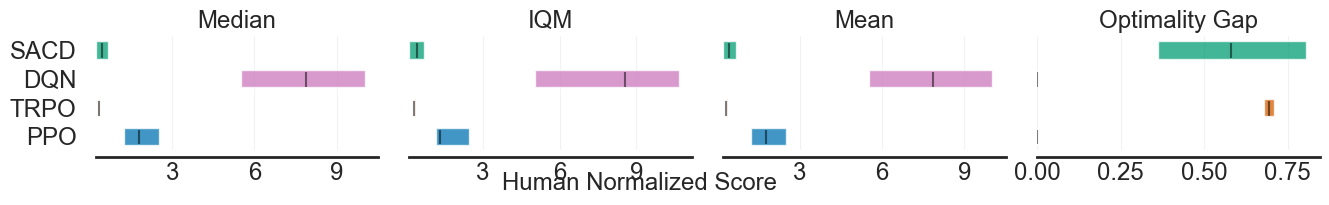

In [22]:
analyze_aggregates(algos, datadict)

In [23]:
def decorate_axis(ax, wrect=10, hrect=10, labelsize='large'):
  # Hide the right and top spines
  ax.spines['right'].set_visible(False)
  ax.spines['top'].set_visible(False)
  ax.spines['left'].set_linewidth(2)
  ax.spines['bottom'].set_linewidth(2)
  # Deal with ticks and the blank space at the origin
  ax.tick_params(length=0.1, width=0.1, labelsize=labelsize)
  # Pablos' comment
  ax.spines['left'].set_position(('outward', hrect))
  ax.spines['bottom'].set_position(('outward', wrect))

# Scores Distribution plots

In [24]:
def plot_score_hist(score_matrix, bins=20, figsize=(28, 14), 
                    fontsize='xx-large', N=6, extra_row=1,
                    names=None):
  num_tasks = score_matrix.shape[1]
  if names is None:
    names = ['Pong-ramDeterministic-v4']
  N1 = (num_tasks // N) + extra_row
  fig, ax = plt.subplots(nrows=N1, ncols=N, figsize=figsize)
  if N1 == 1:
    ax = ax.reshape(1, -1)
  for i in range(N):
    for j in range(N1):
      idx = j * N + i
      if idx < num_tasks:
        ax[j, i].set_title(names[idx], fontsize=fontsize)
        sns.histplot(score_matrix[:, idx], bins=bins, ax=ax[j,i], kde=True)
      else:
        ax[j, i].axis('off')
      decorate_axis(ax[j, i], wrect=5, hrect=5, labelsize='xx-large')
      ax[j, i].xaxis.set_major_locator(plt.MaxNLocator(4))
      if idx % N == 0:
        ax[j, i].set_ylabel('Count', size=fontsize)
      else:
        ax[j, i].yaxis.label.set_visible(False)
      ax[j, i].grid(axis='y', alpha=0.1)
  return fig

In [85]:
# reshape_datasets = np.asarray([v.squeeze() for k, v in datasets.items()])
# reshape_datasets = np.moveaxis(reshape_datasets, -1, 0)

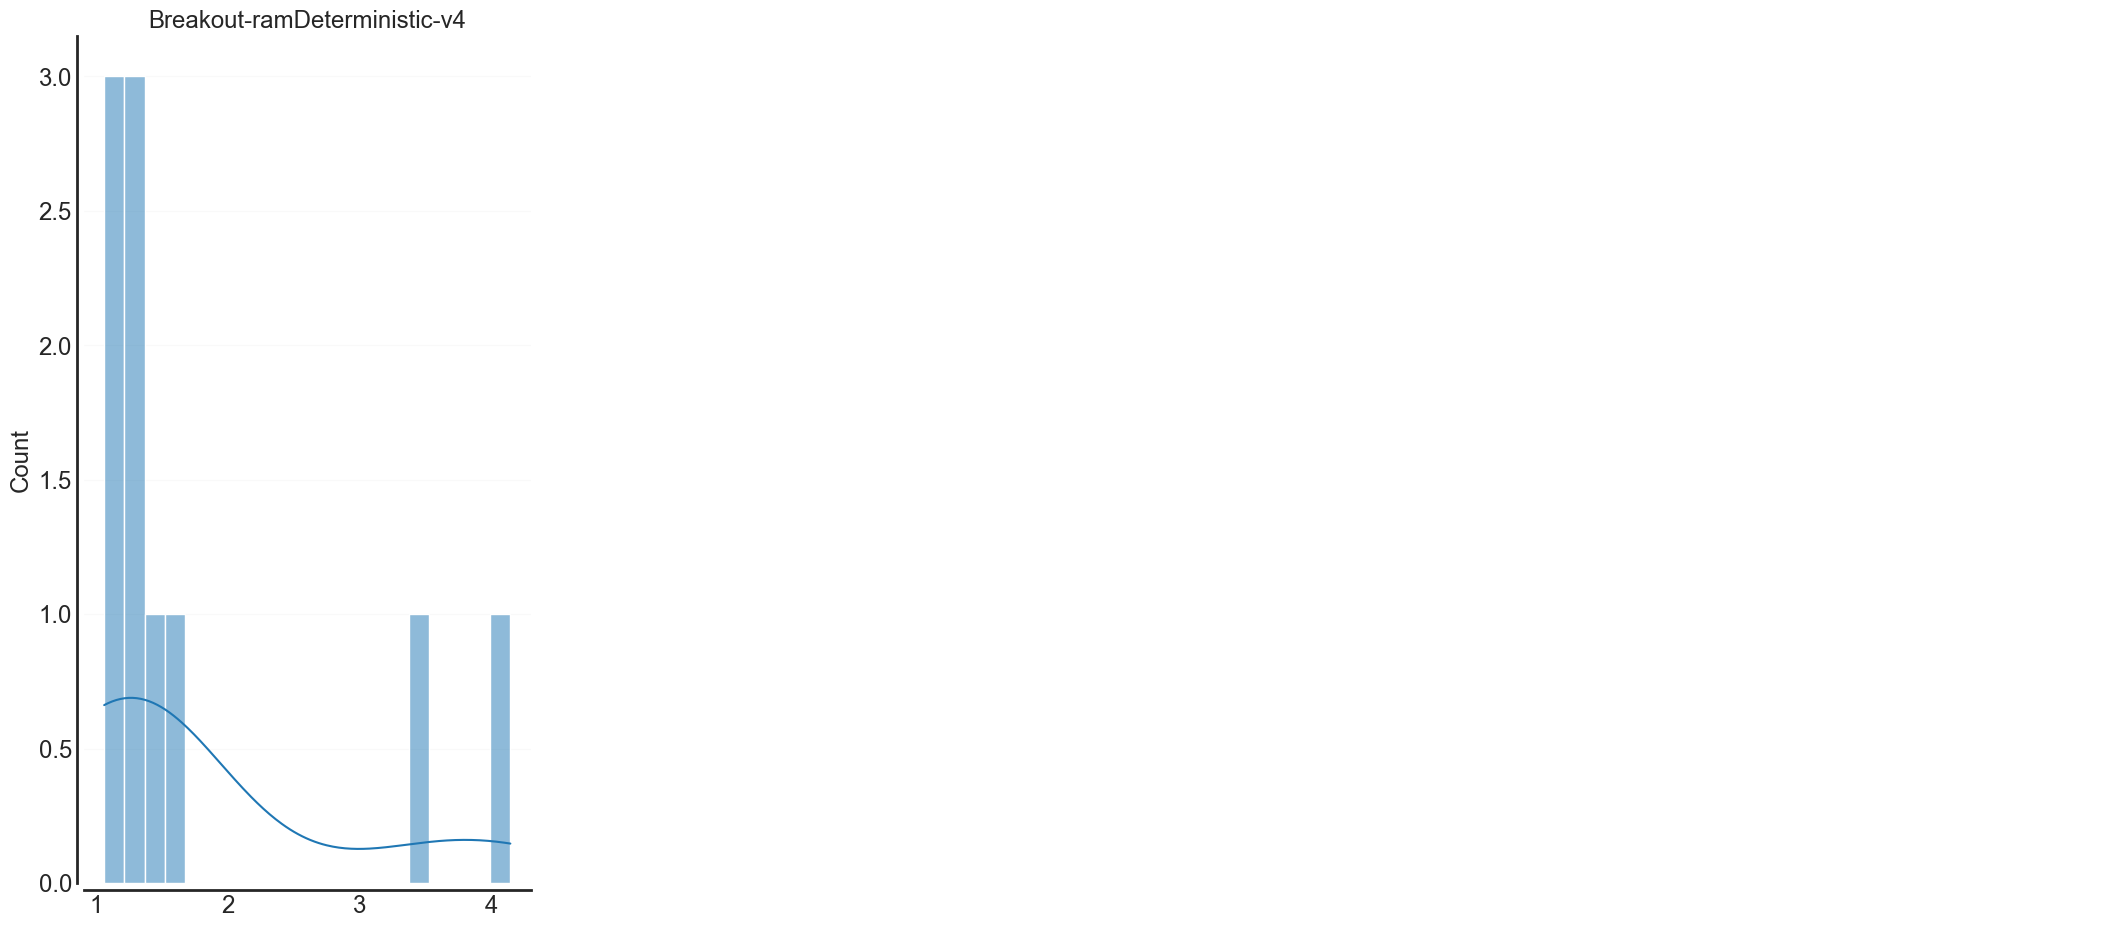

In [25]:
fig = plot_score_hist(datadict['PPO'], bins=20, N=4, figsize=(26, 11), names=tasks)
fig.subplots_adjust(hspace=0.85, wspace=0.17)
plt.show()

# Plot performance profiles (score distributions)

In [27]:
from scipy.stats.stats import find_repeats
#@title Calculate score distributions and average score distributions for for Atari 100k

score_dict = datadict
ATARI_100K_TAU = np.linspace(0.0, 2.0, 201)
# Higher value of reps corresponds to more accurate estimates but are slower
# to computed. `reps` corresponds to number of bootstrap resamples.
reps = 2000

score_distributions, score_distributions_cis = rly.create_performance_profile(
    score_dict, ATARI_100K_TAU, reps=reps)
avg_score_distributions, avg_score_distributions_cis = rly.create_performance_profile(
    score_dict, ATARI_100K_TAU, use_score_distribution=False, reps=reps)

/var/folders/92/kmr0m17d7znfsss5c86hwc500000gn/T/ipykernel_5246/3114951301.py:1: DeprecationWarning: Please import `find_repeats` from the `scipy.stats` namespace; the `scipy.stats.stats` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.stats.stats import find_repeats


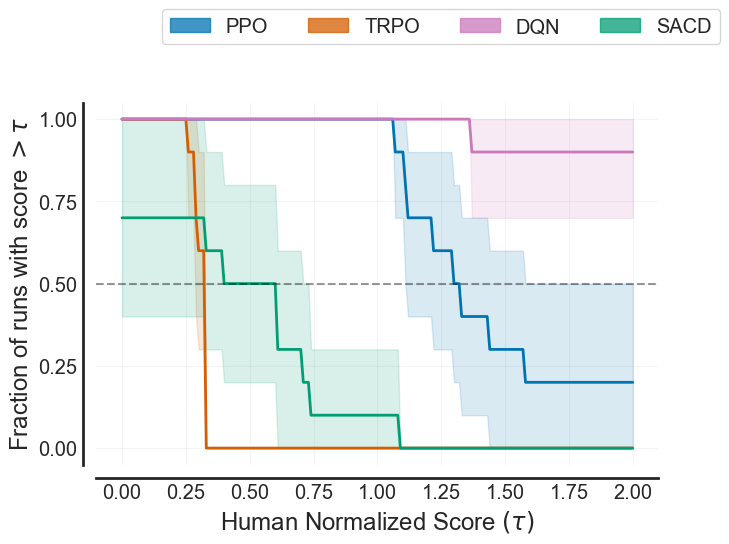

In [28]:
fig, ax = plt.subplots(ncols=1, figsize=(7.25, 4.7))

plot_utils.plot_performance_profiles(
  score_distributions, ATARI_100K_TAU,
  performance_profile_cis=score_distributions_cis,
  colors=color_dict,
  xlabel=r'Human Normalized Score $(\tau)$',
  labelsize='xx-large',
  ax=ax)

ax.axhline(0.5, ls='--', color='k', alpha=0.4)
fake_patches = [mpatches.Patch(color=color_dict[alg], 
                               alpha=0.75) for alg in algos]
legend = fig.legend(fake_patches, algos, loc='upper center', 
                    fancybox=True, ncol=len(algos), 
                    fontsize='x-large',
                    bbox_to_anchor=(0.6, 1.1))

# Plot performance profiles (score distributions) and contrast with average score distribution

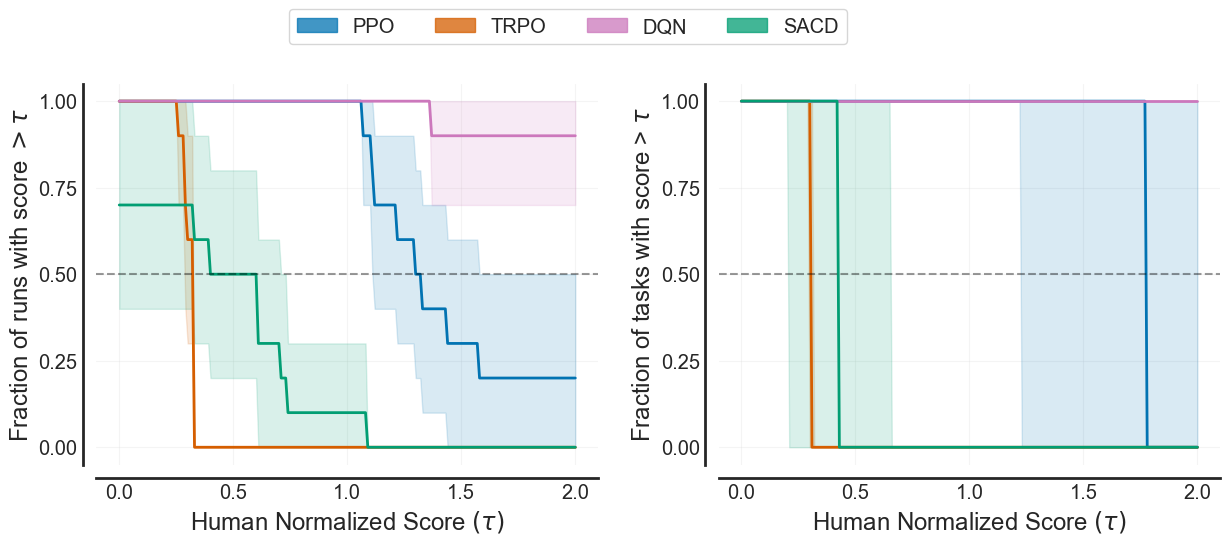

In [29]:
fig, axes = plt.subplots(ncols=2, figsize=(14.5, 4.7))

plot_utils.plot_performance_profiles(
  score_distributions, ATARI_100K_TAU,
  performance_profile_cis=score_distributions_cis,
  colors=color_dict,
  xlabel=r'Human Normalized Score $(\tau)$',
  labelsize='xx-large',
  ax=axes[0])


plot_utils.plot_performance_profiles(
  avg_score_distributions, ATARI_100K_TAU,
  performance_profile_cis=avg_score_distributions_cis,
  colors=color_dict,
  xlabel=r'Human Normalized Score $(\tau)$',
  ylabel=r'Fraction of tasks with score > $\tau$',
  labelsize='xx-large',
  ax=axes[1])

axes[0].axhline(0.5, ls='--', color='k', alpha=0.4)
axes[1].axhline(0.5, ls='--', color='k', alpha=0.4)

fake_patches = [mpatches.Patch(color=color_dict[alg], 
                               alpha=0.75) for alg in algos]
legend = fig.legend(fake_patches, algos, loc='upper center', 
                    fancybox=True, ncol=len(algos), 
                    fontsize='x-large',
                    bbox_to_anchor=(0.45, 1.1))
fig.subplots_adjust(top=0.92, wspace=0.24)

# Performance profiles 

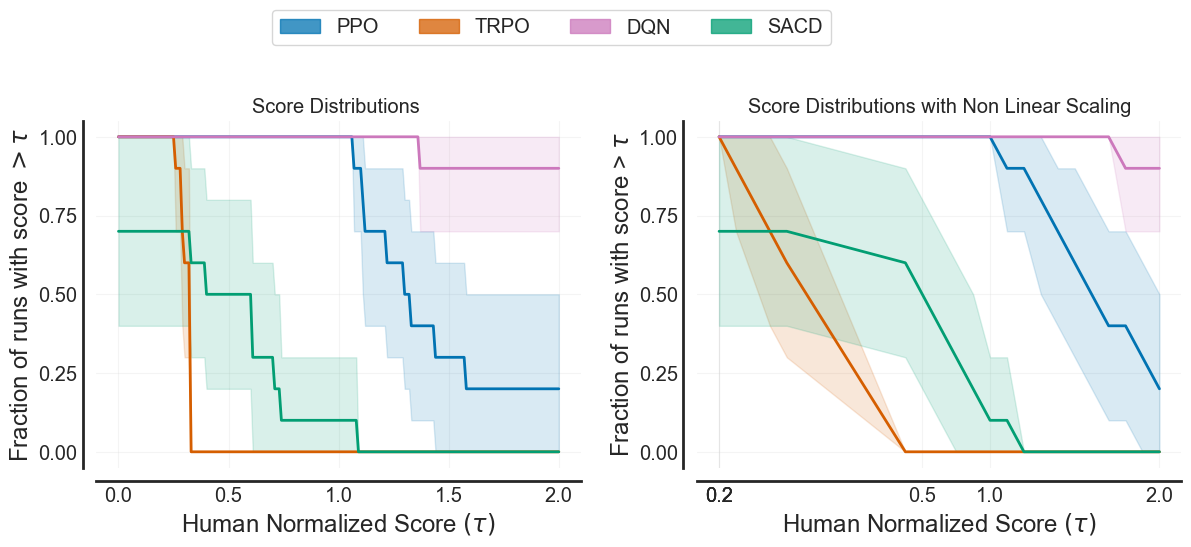

In [30]:
fig, ax = plt.subplots(ncols=2, figsize=(7*2, 4.5))
plot_utils.plot_performance_profiles(
  score_distributions, ATARI_100K_TAU,
  performance_profile_cis=score_distributions_cis,
  colors=color_dict,
  xlabel=r'Human Normalized Score $(\tau)$',
  labelsize='xx-large',
  ax=ax[0])
ax[0].set_title('Score Distributions ', size='x-large')

xticks = [0.0, 0.1, 0.2, 0.5, 1.0, 2.0]
plot_utils.plot_performance_profiles(
  score_distributions, ATARI_100K_TAU,
  performance_profile_cis=score_distributions_cis,
  colors=color_dict,
  xlabel=r'Human Normalized Score $(\tau)$',
  ylabel=r'Fraction of runs with score > $\tau$',
  labelsize='xx-large',
  use_non_linear_scaling=True,
  xticks=xticks,
  ax=ax[1])
ax[1].set_title('Score Distributions with Non Linear Scaling', size='x-large')

fake_patches = [mpatches.Patch(color=color_dict[alg], 
                               alpha=0.75) for alg in algos]
legend = fig.legend(fake_patches, algos, loc='upper center', 
                    fancybox=True, ncol=len(algos), 
                    fontsize='x-large',
                    bbox_to_anchor=(0.45, 1.15))
fig.subplots_adjust(wspace=0.24)

# Probabilities of improvement P(X > Y) with 95% CIs

In [32]:
pairs = []
all_pairs =  {}
for i in range(len(algos)):
  for j in range(len(algos)):
    if j <= i: 
      continue
    pairs.append([algos[i], algos[j]])
    pair_name = f'{algos[i]}_{algos[j]}'
    all_pairs[pair_name] = (
        datadict[algos[i]], datadict[algos[j]]) 

probabilities, probability_cis = {}, {}
reps = 1000
probabilities, probability_cis = rly.get_interval_estimates(
    all_pairs, metrics.probability_of_improvement, reps=reps)

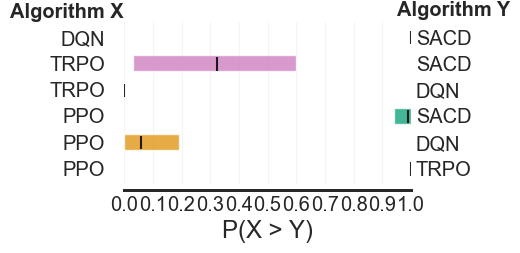

In [33]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(3.7, 2.1))
h = 0.6

ax2 = ax.twinx()
colors = sns.color_palette('colorblind')

for i, (pair, p) in enumerate(probabilities.items()):  
  (l, u), p  = probability_cis[pair], p

  ax.barh(y=i, width=u-l, height=h, 
          left=l, color=colors[i], 
          alpha=0.75, label=pair[0])
  ax2.barh(y=i, width=u-l, height=h, 
          left=l, color=colors[i], 
          alpha=0.0, label=pair[1])
  ax.vlines(x=p, ymin=i-7.5 * h/16, ymax=i+(6*h/16),
            color='k', alpha=0.85)
  

ax.set_yticks(list(range(len(pairs))))
ax2.set_yticks(range(len(pairs)))
pairs = [x.split('_') for x in probabilities.keys()]
ax2.set_yticklabels([pair[1] for pair in pairs], fontsize='large')
ax.set_yticklabels([pair[0] for pair in pairs], fontsize='large')
ax2.set_ylabel('Algorithm Y', fontweight='bold', rotation='horizontal', fontsize='x-large')
ax.set_ylabel('Algorithm X', fontweight='bold', rotation='horizontal', fontsize='x-large')
ax.set_xticks([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
ax.yaxis.set_label_coords(-0.2, 1.0)
ax2.yaxis.set_label_coords(1.15, 1.13)
decorate_axis(ax, wrect=5)
decorate_axis(ax2, wrect=5)
       
ax.tick_params(axis='both', which='major', labelsize='x-large')
ax2.tick_params(axis='both', which='major', labelsize='x-large')
ax.set_xlabel('P(X > Y)', fontsize='xx-large')
ax.grid(axis='x', alpha=0.2)
plt.subplots_adjust(wspace=0.05)
ax.spines['left'].set_visible(False)
ax2.spines['left'].set_visible(False)


plt.show()

# Training analysis

In [34]:
def load_data(
        algos, 
        data_files,  
        evaluation_keys = ['EpRet'],
    ):
    # load datasets
    datasets = {}
    for algo, filename in zip(algos, data_files):
        df = pd.read_table(filename)
        keys = []
        dkeys = {}
        for k in evaluation_keys:
            if str('AverageTest' + k) in df.keys():
                keys.append('AverageTest' + k)
            elif str('Average' + k) in df.keys():
                keys.append('Average' + k)
            elif k in df.keys():
                keys.append(k)
            dkeys[keys[-1]] = k
        
        datasets[algo] = df[keys]
        datasets[algo] = datasets[algo].rename(columns=dkeys)
    return datasets

In [44]:
algos = ['SACD']
data_files = [
    # '/Users/khuongle/Documents/4th-semester/cs492/spinningup_stable/spinningup/data/ppo_Breakout-ramDeterministic-v4/ppo_Breakout-ramDeterministic-v4_s928/progress.txt',
    # '/Users/khuongle/Documents/4th-semester/cs492/spinningup_stable/spinningup/data/trpo_Breakout-ramDeterministic-v4/trpo_Breakout-ramDeterministic-v4_s746/progress.txt',
    '/Users/khuongle/Documents/4th-semester/cs492/spinningup_stable/spinningup/data/sacd_Breakout-ramDeterministic-v4/sacd_Breakout-ramDeterministic-v4_s923/progress.txt',
    # '/Users/khuongle/Documents/4th-semester/cs492/spinningup_stable/spinningup/data/sacd_Breakout-ramDeterministic-v4/sacd_Breakout-ramDeterministic-v4_s923/progress.txt'
]
env = 'Breakout-ramDeterministic-v4'
evaluation_keys = ['CurAlpha', 'TotalEnvInteracts']

In [45]:
datasets = load_data(algos, data_files, evaluation_keys)
datasets

{'SACD':          CurAlpha  TotalEnvInteracts
 0    9.567530e-01               8000
 1    8.639427e-01              12000
 2    7.690629e-01              16000
 3    6.844189e-01              20000
 4    6.092385e-01              24000
 ..            ...                ...
 495  8.199574e-11            1988000
 496  8.199574e-11            1992000
 497  8.199574e-11            1996000
 498  8.199574e-11            2000000
 499  8.199574e-11            2004000
 
 [500 rows x 2 columns]}

In [38]:
def plot(score_dict, figsize=(28, 14), xaxis=None,
        yaxis=None, fontsize='xx-large', names=None):
  N = len(algos)
  fig, ax = plt.subplots(nrows=1, ncols=N, figsize=figsize)
  ax = ax.reshape(1, -1)
  for i in range(N):
    ax[0, i].set_title(names[i], fontsize=fontsize)
    sns.lineplot(score_dict[names[i]], x=xaxis, y=yaxis, ax=ax[0,i])
    if i % N == 0:
      ax[0, i].set_ylabel(yaxis, size=fontsize)
    else:
      ax[0, i].yaxis.label.set_visible(False)
    ax[0, i].grid(axis='y', alpha=0.1)
  return fig

In [39]:
def separate_plot(score_dict, figsize=(28, 14), xaxis=None,
                yaxis=None, fontsize='xx-large', names=None):
    N = len(algos)
    for i in range(N):
        plt.figure()
        plt.title(algos[i])
        sns.lineplot(score_dict[names[i]], x=xaxis, y=yaxis)
        plt.show()
        

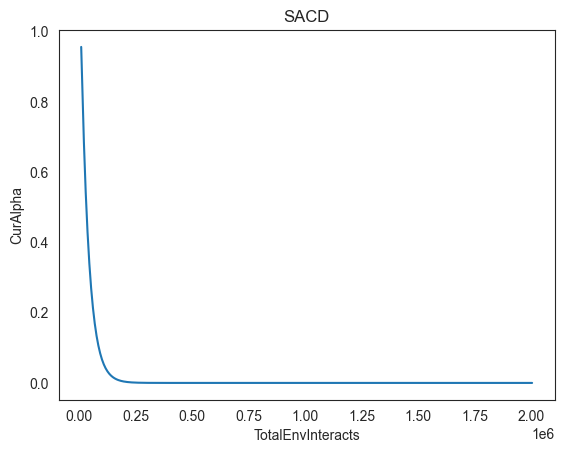

In [46]:
separate_plot(datasets, xaxis=evaluation_keys[1], yaxis=evaluation_keys[0], figsize=(32, 16), names=algos)

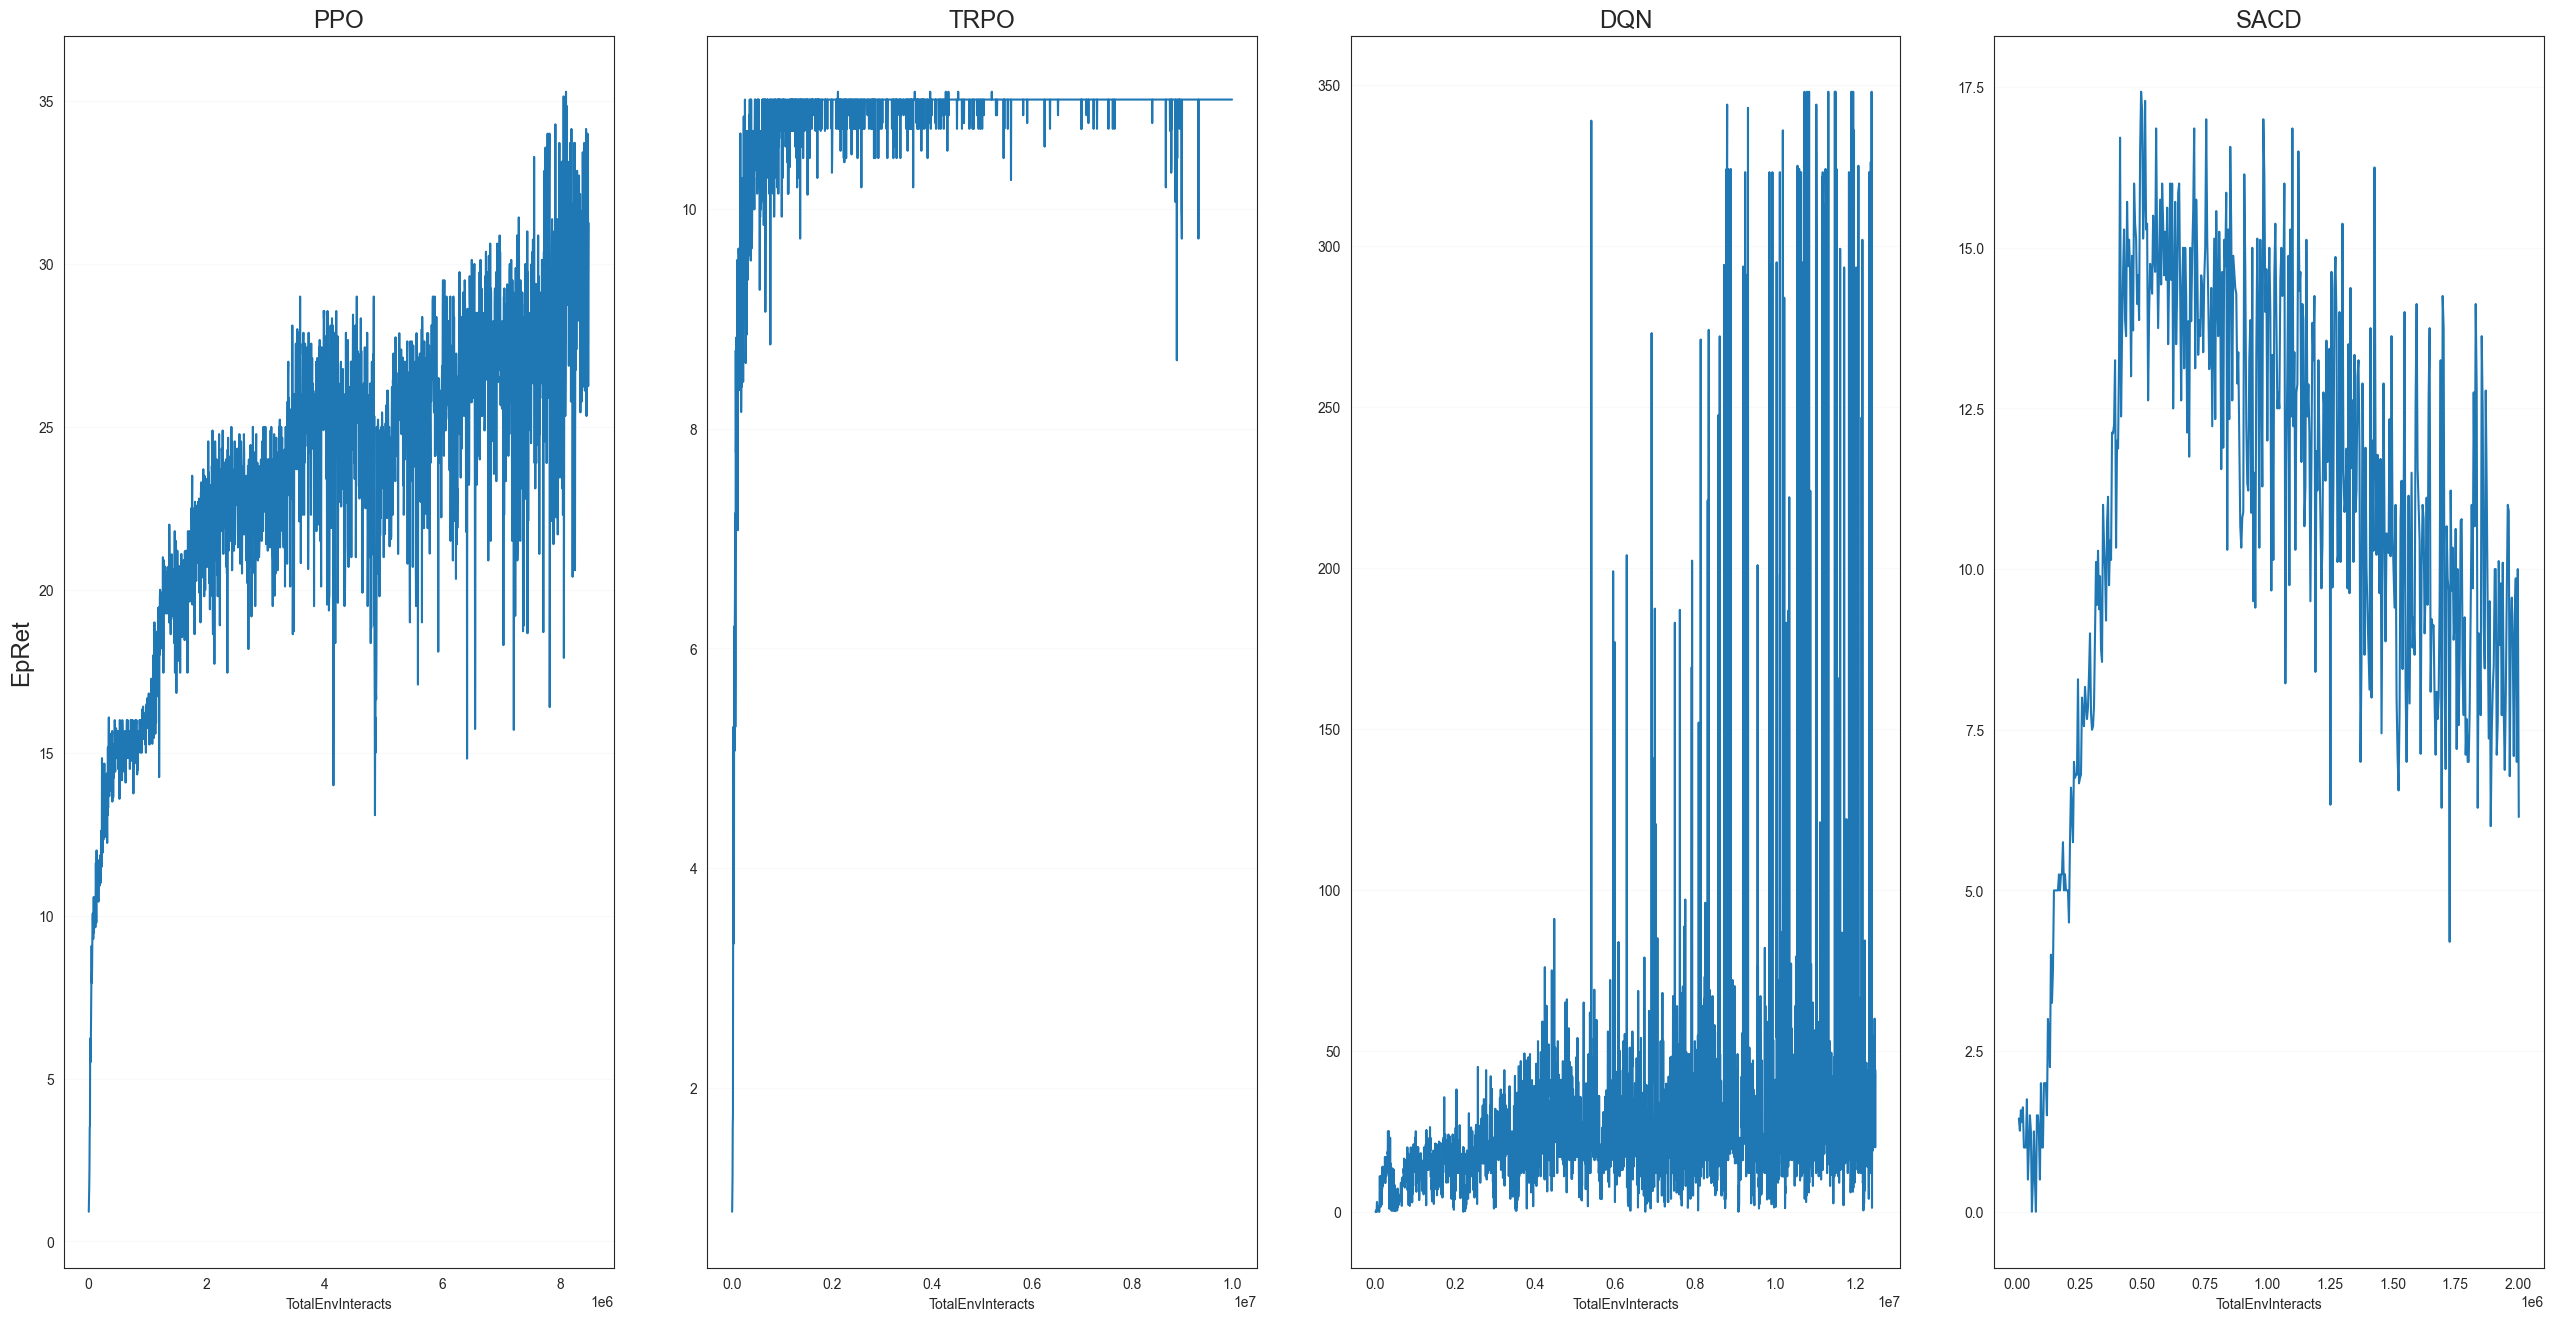

In [133]:
fig = plot(datasets, xaxis=evaluation_keys[1], yaxis=evaluation_keys[0], figsize=(32, 16), names=algos)
fig.subplots_adjust(hspace=0.85, wspace=0.17)
plt.show()